In [1]:
import os
import nltk
import time
import datetime
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from scipy.sparse import hstack

from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, roc_curve, mean_squared_error, make_scorer, confusion_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, StratifiedKFold, validation_curve, StratifiedShuffleSplit
from sklearn.feature_extraction import text

from utility.processing import *
from utility.utility import *

from imblearn.combine import *
from imblearn.over_sampling import *
from imblearn.under_sampling import * 
from imblearn.pipeline import Pipeline, make_pipeline

from joblib import Parallel, delayed
%matplotlib inline

# Crowdflower Search Results Relevance

## 데이터 로드

In [2]:
train = pd.read_csv('./data/preprocessed_train.csv')
train = train.drop_duplicates(['query_preprocessed', 'product_title_preprocessed'])
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)
y = train.median_relevance.values

In [3]:
train, dev, y, y_dev = train_test_split(train, y, stratify=y, test_size=0.1)

In [4]:
for i in range(1, 5):
    print('number of median_relevance %d: '%i, len(train.groupby('median_relevance').get_group(i)))

number of median_relevance 1:  684
number of median_relevance 2:  1297
number of median_relevance 3:  1516
number of median_relevance 4:  5333


In [5]:
for i in range(1, 5):
    print('number of median_relevance %d: '%i, len(dev.groupby('median_relevance').get_group(i)))

number of median_relevance 1:  76
number of median_relevance 2:  144
number of median_relevance 3:  169
number of median_relevance 4:  593


In [6]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

dev_query = list(dev.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
dev_title = list(dev.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

## 모델링

### TF-IDF

In [7]:
# min_df=7 : 빈도수가 7번 이하인 단어 무시
# max_features=None : 단어 빈도수의 맥시멈 설정 x
# strip_accents='unicode' : 모든 특수문자와 pattern을 정재할수 없으므로 unicode사용
# analyzer='word' : corpus가 문장 list로 이루어져있어 단어단위로 분석
# token_pattern=r'\w{1,}' : analyzer == 'word'일 때 token_pattern을 기반으로 단어 인식
# ngram_range=(1, 3) : word window의 범위 1~3, 약 90% 쿼리가 word size 3이하로 이루어짐
# use_idf=True : idf사용
# smooth_idf=True : 분모가 0이 되는것을 방지
# sublinear_tf=True : 단어 스무딩, replace 1 + log(tf).
# stop_words : 불용어 제거
stop_words = text.ENGLISH_STOP_WORDS.union(['http', 'www', 'img', 'border', 'color', 'style', 'padding', 'table', 'font', '',
                                            'thi', 'inch', 'ha', 'width', 'height', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))

tfv = text.TfidfVectorizer(min_df=7, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                           ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                           stop_words=stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_dev = hstack([tfv.transform(dev_query), tfv.transform(dev_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])

In [8]:
# 단어별 가중치 확인
# idf_dict = dict(zip(tfv.get_feature_names(), tfv.idf_))

### cos, jaccard similarlity stack

In [9]:
# query, title 유사도 계산(cos, jaccard)
sim = similarlity_stack()
X_sim_train = sim.fit_transform(X_train, y)
X_sim_dev = sim.transform(X_dev)
X_sim_test = sim.transform(X_test)

In [10]:
for i in range(1, 5):
    sims = X_sim_train.toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \ncos_sim mean : %f\t jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ratings 1 
cos_sim mean : 0.164354	 jaccard_sim mean: 0.107674

ratings 2 
cos_sim mean : 0.276310	 jaccard_sim mean: 0.189937

ratings 3 
cos_sim mean : 0.346352	 jaccard_sim mean: 0.240954

ratings 4 
cos_sim mean : 0.441215	 jaccard_sim mean: 0.314409



#### LogisticRegression

In [11]:
lr = LogisticRegression(max_iter=500)

X_train_sim = hstack([X_train, X_sim_train])
X_dev_sim = hstack([X_dev, X_sim_dev])

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(lr, X_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("lr without sim kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

kappa_scores = cross_val_score(lr, X_train_sim, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("lr with sim kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

lr without sim kappa score 평균 : 0.48, 편차 : 0.01
lr with sim kappa score 평균 : 0.58, 편차 : 0.01


### LSA

In [12]:
# TruncatedSVD
# 261개의 쿼리이므로 n_components = 250로 모델링 시작
svd = TruncatedSVD(n_components = 250)
X_svd_train = svd.fit_transform(X_train)
X_svd_dev = svd.transform(X_dev)
X_svd_test = svd.transform(X_test)

In [13]:
# Truncated SVD와 유사도 hstack
X_stacked_train = hstack([X_svd_train, X_sim_train])
X_stacked_dev = hstack([X_svd_dev, X_sim_dev])
X_stacked_test = hstack([X_svd_test, X_sim_test])

In [14]:
# StandardScaler
# with_mean=False 행렬이 희소하고 [0,1]이므로 mean shift사용 X
scl = StandardScaler(with_mean=False)
X_scaled_train = scl.fit_transform(X_stacked_train)
X_scaled_dev = scl.transform(X_stacked_dev)
X_scaled_test = scl.transform(X_stacked_test)

In [15]:
for i in range(1, 5):
    sims = X_scaled_train[:,-2:].toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \nscaled cos_sim mean : %f\t scaled jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ratings 1 
scaled cos_sim mean : 0.700075	 scaled jaccard_sim mean: 0.530089

ratings 2 
scaled cos_sim mean : 1.176958	 scaled jaccard_sim mean: 0.935078

ratings 3 
scaled cos_sim mean : 1.475310	 scaled jaccard_sim mean: 1.186239

ratings 4 
scaled cos_sim mean : 1.879383	 scaled jaccard_sim mean: 1.547866



### classification

#### LogisticRegression

In [16]:
lr = LogisticRegression(max_iter=500)

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(lr, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)

print("scaled lr kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

scaled lr kappa score 평균 : 0.52, 편차 : 0.01


#### SVM

In [17]:
# C=100(패널티) 문서당 유사도가 크기때문에(쿼리의 중복) 100으로 잡고 시작
svm = SVC(C = 100, gamma='auto', probability=True)

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(svm, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("svm kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

svm kappa score 평균 : 0.60, 편차 : 0.01


## 모델링 결과 해석

kappa
train : 0.944631	dev : 0.651879
rmse
train : 0.327141	dev : 0.821057

confusion_matrix : 982개중 335개를 틀림
 [[ 44  21   4   7]
 [ 17  57  27  43]
 [ 13  28  40  88]
 [  2  25  60 506]]

classification_report :
               precision    recall  f1-score   support

           1       0.58      0.58      0.58        76
           2       0.44      0.40      0.41       144
           3       0.31      0.24      0.27       169
           4       0.79      0.85      0.82       593

    accuracy                           0.66       982
   macro avg       0.53      0.52      0.52       982
weighted avg       0.64      0.66      0.65       982



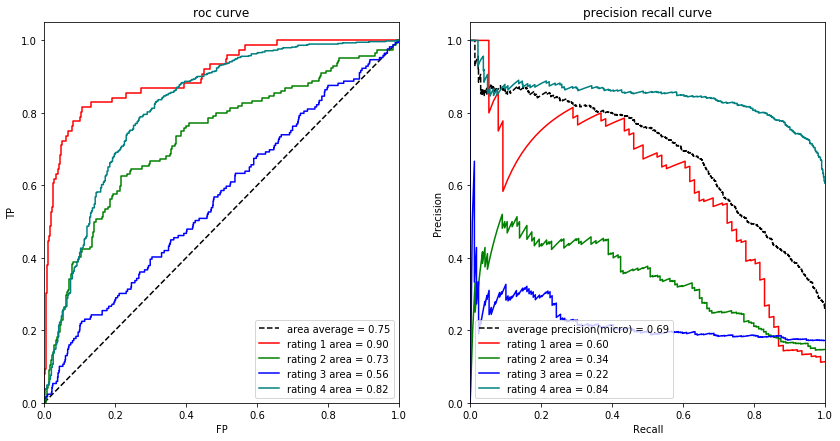

In [18]:
svm_result = svm.fit(X_scaled_train, y)
svm_pred_train = svm_result.predict(X_scaled_train)
svm_pred_dev = svm_result.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y, svm_pred_train), \
                                      metric.quadratic_weighted_kappa(y_dev, svm_pred_dev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y, svm_pred_train)**0.5, \
                                     mean_squared_error(y_dev, svm_pred_dev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svm_pred_dev!=y_dev)[0])), \
      confusion_matrix(y_dev, svm_pred_dev))
print('\nclassification_report :\n', classification_report(y_dev, svm_pred_dev))

plot_multiclass_roc_prc(svm, X_scaled_dev, y_dev)

## 개선된 모델

### Over sampling(SVMSMOTE)

#### gridsearch k_neighbors for SVMSMOTE

In [19]:
from sklearn.base import clone

In [20]:
def _svm_smote(svm, smt, X, Y, train_index, test_index):
    print('sampling start')
    X_samp, y_samp = smt.fit_sample(X[train_index], Y[train_index])
    svm_result = svm.fit(X_samp, y_samp)
    svm_pred_dev = svm_result.predict(X[test_index])
    svm_pred_proba_dev = svm_result.predict_proba(X[test_index])
    print('end')
    return metric.quadratic_weighted_kappa(Y[test_index], svm_pred_dev), metric.pr_auc_score(Y[test_index], svm_pred_proba_dev)

In [21]:
_k_fold = StratifiedKFold(n_splits=4, shuffle=True)
parallel = Parallel(n_jobs=2)

svm = SVC(C=10, gamma='auto', psobability=True)
scores_list = []
for k in range(1, 11):
    smt = SVMSMOTE(sampling_strategy='not majority', svm_estimator=SVC(C=100, gamma='auto'), n_jobs=2, k_neighbors=k)
    scores = parallel(
        delayed(_svm_smote)(clone(svm), clone(smt), X_scaled_train, y, train_index, test_index) 
        for train_index, test_index in _k_fold.split(X_scaled_train, y)
    )
    scores_list.append(scores)

In [22]:
kappa_test_scores_mean, kappa_test_scores_std, auc_test_scores_mean,auc_test_scores_std = [], [], [], []
for score_static in scores_list:
    kappa_test_scores_mean.append(np.mean(score_static, axis=0)[0])
    kappa_test_scores_std.append(np.std(score_static, axis=0)[0])
    auc_test_scores_mean.append(np.mean(score_static, axis=0)[1])
    auc_test_scores_std.append(np.std(score_static, axis=0)[1])
kappa_test_scores_mean = np.array(kappa_test_scores_mean)
kappa_test_scores_std = np.array(kappa_test_scores_std)
auc_test_scores_mean = np.array(auc_test_scores_mean)
auc_test_scores_std = np.array(auc_test_scores_std)

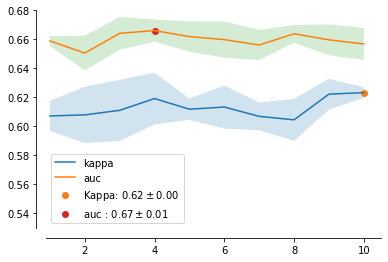

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

param_range = range(1, 11)
plt.plot(param_range, kappa_test_scores_mean, label='kappa')
ax.fill_between(param_range, kappa_test_scores_mean + kappa_test_scores_std,
                kappa_test_scores_mean - kappa_test_scores_std, alpha=0.2)
kappa_idx_max = np.argmax(kappa_test_scores_mean)
plt.scatter(param_range[kappa_idx_max], kappa_test_scores_mean[kappa_idx_max],
            label=r'Kappa: ${:.2f}\pm{:.2f}$'.format(kappa_test_scores_mean[kappa_idx_max], kappa_test_scores_std[kappa_idx_max]))

plt.plot(param_range, auc_test_scores_mean, label='auc')
ax.fill_between(param_range, auc_test_scores_mean + auc_test_scores_std,
                auc_test_scores_mean - auc_test_scores_std, alpha=0.2)
auc_idx_max = np.argmax(auc_test_scores_mean)
plt.scatter(param_range[auc_idx_max], auc_test_scores_mean[auc_idx_max],
            label=r'auc : ${:.2f}\pm{:.2f}$'.format(auc_test_scores_mean[auc_idx_max], auc_test_scores_std[auc_idx_max]))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0.9, 10.5])
plt.ylim([0.53, 0.68])

plt.legend(loc="best")
plt.show()

#### SVMSMOTE result

sampling finish
fitting finish
kappa
train : 0.928763	dev : 0.674133
rmse
train : 0.423226	dev : 0.788151

confusion_matrix : 982개중 343개를 틀림
 [[ 49  17   3   7]
 [ 17  58  39  30]
 [ 10  25  62  72]
 [  2  22  99 470]]

classification_report :
               precision    recall  f1-score   support

           1       0.63      0.64      0.64        76
           2       0.48      0.40      0.44       144
           3       0.31      0.37      0.33       169
           4       0.81      0.79      0.80       593

    accuracy                           0.65       982
   macro avg       0.56      0.55      0.55       982
weighted avg       0.66      0.65      0.65       982



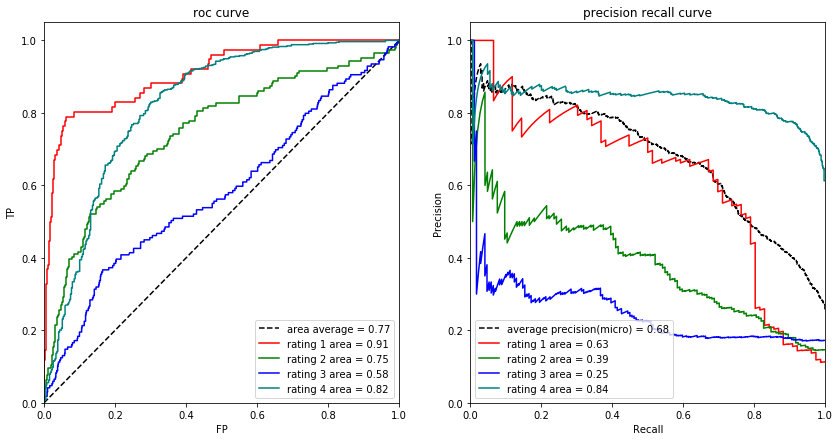

In [24]:
svmsmote = SVMSMOTE(sampling_strategy='not majority', k_neighbors=4, svm_estimator=SVC(C=10), n_jobs=-1)
X_samp, y_samp = svmsmote.fit_sample(X_scaled_train, y)
print('sampling finish')
svm = SVC(C=10, probability=True)
svmresult = svm.fit(X_samp, y_samp)
print('fitting finish')
svmpredtrain = svmresult.predict(X_samp)
svm_over_train_proba = svmresult.predict_proba(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)
svm_over_dev_proba = svmresult.predict_proba(X_scaled_dev)
svm_over_dev_score = svmresult.decision_function(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)

### Data augmentation

In [25]:
df_train = pd.read_csv('./data/preprocessed_eda_train.csv')
# df_train.set_index('id', inplace=True)
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)
# test.set_index('id', inplace=True)

Y = df_train['median_relevance']
df_train = df_train[['id', 'query_preprocessed', 'product_title_preprocessed', 'median_relevance']]
df_train.drop_duplicates(keep='first', inplace=True)
test = test[['id', 'query_preprocessed', 'product_title_preprocessed']]

for i in range(1, 5):
    print('number of median_relevance %d: '%i, len(df_train.groupby('median_relevance').get_group(i)))

number of median_relevance 1:  8983
number of median_relevance 2:  9894
number of median_relevance 3:  11617
number of median_relevance 4:  10297


In [26]:
train = df_train[df_train['id'].isin(train['id'].values)]
dev = df_train[df_train['id'].isin(dev['id'].values)].drop_duplicates(subset='id', keep='first')

y = train['median_relevance']
y_dev = dev['median_relevance']

In [27]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

dev_query = list(dev.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
dev_title = list(dev.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

In [28]:
stop_words = text.ENGLISH_STOP_WORDS.union(['http', 'www', 'img', 'border', 'color', 'style', 'padding', 'table', 'font', '',
                                            'thi', 'inch', 'ha', 'width', 'height', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))

tfv = text.TfidfVectorizer(min_df=7, max_df=0.9, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                           ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                           stop_words=stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_dev = hstack([tfv.transform(dev_query), tfv.transform(dev_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])

In [29]:
sim = similarlity_stack()
X_sim_train = sim.fit_transform(X_train, y)
X_sim_dev = sim.transform(X_dev)
X_sim_test = sim.transform(X_test)

for i in range(1, 5):
    sims = X_sim_train[:,-2:].toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \n cos_sim mean : %f\t jaccard_sim mean : %f\n" % (i, sims[0], sims[1]))

ratings 1 
 cos_sim mean : 0.089474	 jaccard_sim mean : 0.060424

ratings 2 
 cos_sim mean : 0.189796	 jaccard_sim mean : 0.131674

ratings 3 
 cos_sim mean : 0.248571	 jaccard_sim mean : 0.171338

ratings 4 
 cos_sim mean : 0.380586	 jaccard_sim mean : 0.270181



In [30]:
svd = TruncatedSVD(n_components = 230)
X_svd_train = svd.fit_transform(X_train)
X_svd_dev = svd.transform(X_dev)
X_svd_test = svd.transform(X_test)

X_stacked_train = hstack([X_svd_train, X_sim_train])
X_stacked_dev = hstack([X_svd_dev, X_sim_dev])
X_stacked_test = hstack([X_svd_test, X_sim_test])

scl = StandardScaler(with_mean=False)
X_scaled_train = scl.fit_transform(X_stacked_train)
X_scaled_dev = scl.transform(X_stacked_dev)
X_scaled_test = scl.transform(X_stacked_test)

for i in range(1, 5):
    sims = X_scaled_train[:,-2:].toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \nscaled cos_sim mean : %f\t scaled jaccard_sim mean : %f\n" % (i, sims[0], sims[1]))

ratings 1 
scaled cos_sim mean : 0.448236	 scaled jaccard_sim mean : 0.386173

ratings 2 
scaled cos_sim mean : 0.950818	 scaled jaccard_sim mean : 0.841532

ratings 3 
scaled cos_sim mean : 1.245258	 scaled jaccard_sim mean : 1.095028

ratings 4 
scaled cos_sim mean : 1.906612	 scaled jaccard_sim mean : 1.726742



In [31]:
C=10
svm = SVC(C=C, gamma='auto', probability=True)
svm_result = svm.fit(X_scaled_train, y)

svm_pred_train = svm_result.predict(X_scaled_train)
svm_eda_train_proba = svm_result.predict_proba(X_scaled_train)
svm_pred_dev = svm_result.predict(X_scaled_dev)
svm_eda_dev_proba = svm_result.predict_proba(X_scaled_dev)
svm_eda_dev_score = svm_result.decision_function(X_scaled_dev)

#### Data augmentation result

kappa
train : 0.838300	dev : 0.684013
rmse
train : 0.636871	dev : 0.783615

confusion_matrix : 982개중 309개를 틀림
 [[ 50  18   0   8]
 [ 18  58  27  41]
 [  8  25  41  95]
 [  1  25  43 524]]

classification_report :
               precision    recall  f1-score   support

           1       0.65      0.66      0.65        76
           2       0.46      0.40      0.43       144
           3       0.37      0.24      0.29       169
           4       0.78      0.88      0.83       593

    accuracy                           0.69       982
   macro avg       0.57      0.55      0.55       982
weighted avg       0.66      0.69      0.67       982

00:27:19


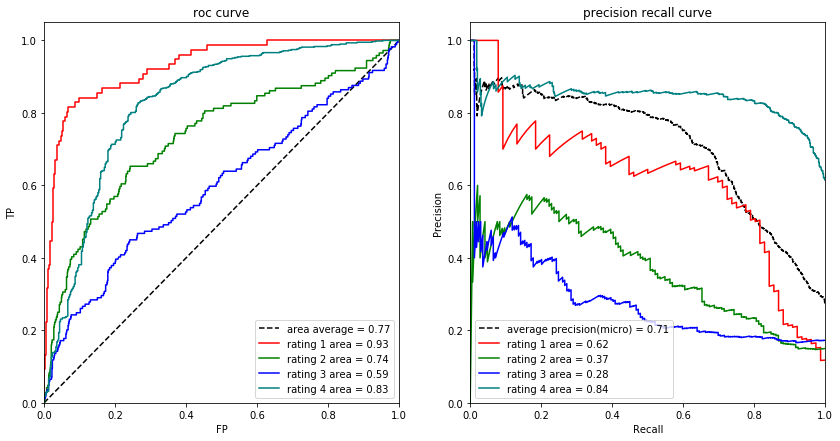

In [32]:
print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y, svm_pred_train), \
                                      metric.quadratic_weighted_kappa(y_dev, svm_pred_dev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y, svm_pred_train)**0.5, \
                                     mean_squared_error(y_dev, svm_pred_dev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svm_pred_dev!=y_dev)[0])), \
      confusion_matrix(y_dev, svm_pred_dev))
print('\nclassification_report :\n', classification_report(y_dev, svm_pred_dev))

now = time.localtime()
print("%02d:%02d:%02d"%(now.tm_hour, now.tm_min, now.tm_sec))
plot_multiclass_roc_prc(svm, X_scaled_dev, y_dev)

### Over sampling + Data augmentation

#### Over sampling + Data augmentation result

sampling finish
fitting finish
kappa
train : 0.871277	dev : 0.653095
rmse
train : 0.572615	dev : 0.826619

confusion_matrix : 982개중 361개를 틀림
 [[ 45  24   2   5]
 [ 18  67  34  25]
 [ 11  33  54  71]
 [  6  36  96 455]]

classification_report :
               precision    recall  f1-score   support

           1       0.56      0.59      0.58        76
           2       0.42      0.47      0.44       144
           3       0.29      0.32      0.30       169
           4       0.82      0.77      0.79       593

    accuracy                           0.63       982
   macro avg       0.52      0.54      0.53       982
weighted avg       0.65      0.63      0.64       982



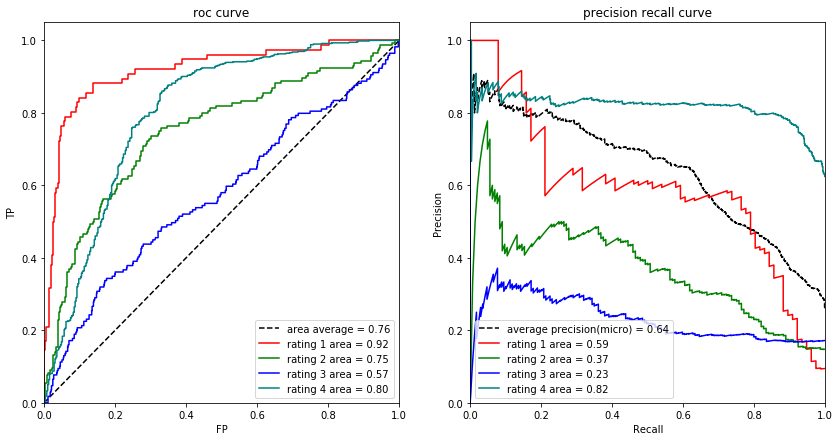

In [33]:
svmsmote = SVMSMOTE(sampling_strategy='not majority', k_neighbors=4, svm_estimator=SVC(C=10), n_jobs=-1)
X_samp, y_samp = svmsmote.fit_sample(X_scaled_train, y)
print('sampling finish')
svm = SVC(C=10, probability=True)
svmresult = svm.fit(X_samp, y_samp)
print('fitting finish')
svmpredtrain = svmresult.predict(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)

### Ensemble

#### Soft Voting Ensemble

In [34]:
svm_ensemble_dev = (svm_over_dev_proba + svm_eda_dev_proba) / 2
svm_ensemble_dev_score = (svm_over_dev_score + svm_eda_dev_score) / 2
ensemble_pred = np.argmax(svm_ensemble_dev, axis=1)+1

#### Soft Voting Ensemble result

In [35]:
print("kappa\ndev : %f"% (metric.quadratic_weighted_kappa(y_dev, ensemble_pred)))

print("rmse\ndev : %f"% (mean_squared_error(y_dev, ensemble_pred)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(ensemble_pred!=y_dev)[0])), \
      confusion_matrix(y_dev, ensemble_pred))
print('\nclassification_report :\n', classification_report(y_dev, ensemble_pred))

kappa
dev : 0.375612
rmse
dev : 1.088264

confusion_matrix : 982개중 423개를 틀림
 [[ 29  15   9  23]
 [ 16  33  25  70]
 [ 10  15  37 107]
 [ 20  43  70 460]]

classification_report :
               precision    recall  f1-score   support

           1       0.39      0.38      0.38        76
           2       0.31      0.23      0.26       144
           3       0.26      0.22      0.24       169
           4       0.70      0.78      0.73       593

    accuracy                           0.57       982
   macro avg       0.41      0.40      0.41       982
weighted avg       0.54      0.57      0.55       982



In [36]:
fpr, tpr, roc_auc = {}, {}, {}
y_dummies = pd.get_dummies(y_dev, drop_first=False).values

for i in range(1, 5):
    fpr[i], tpr[i], _ = roc_curve(y_dummies[:, i-1], svm_ensemble_dev[:, i-1])
    roc_auc[i] = auc(fpr[i], tpr[i])

Y_bin = label_binarize(y_dev, classes=[1, 2, 3, 4])
precision, recall, average_precision = {}, {}, {}
for i in range(1, 5):
    precision[i], recall[i], _ = precision_recall_curve(Y_bin[:, i-1], svm_ensemble_dev[:, i-1])
    average_precision[i] = average_precision_score(Y_bin[:, i-1], svm_ensemble_dev[:, i-1])
    
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_bin.ravel(), svm_ensemble_dev.ravel())
average_precision["micro"] = average_precision_score(Y_bin, svm_ensemble_dev, average="micro")

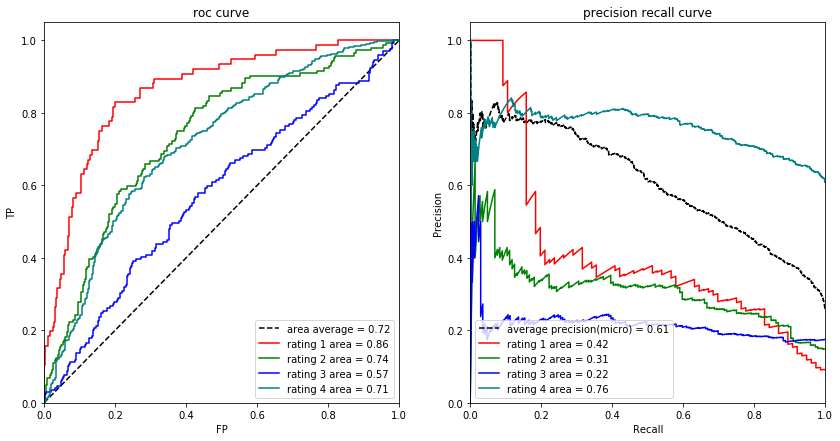

In [37]:
fig, axes = plt.subplots(1,2, figsize =(14, 7))
colors = ['k', 'r', 'g', 'b', 'teal']

axes[0].plot([0, 1], [0, 1], 'k--', label='area average = %0.2f' % (sum(roc_auc.values())/len(roc_auc.values())))
for i in range(1, 5):
    axes[0].plot(fpr[i], tpr[i], color=colors[i], label='rating %i area = %0.2f' % (i, roc_auc[i]))
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('FP')
axes[0].set_ylabel('TP')
axes[0].set_title('roc curve')
axes[0].legend(loc="lower right")

axes[1].plot(recall['micro'], precision['micro'], 'k--', label='average precision(micro) = %0.2f' % average_precision["micro"])
for i in range(1, 5):
    axes[1].plot(recall[i], precision[i], color=colors[i], label = 'rating %i area = %0.2f' % (i, average_precision[i]))
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('precision recall curve')
axes[1].legend(loc="lower left")

plt.show()